# First do Primakoff re-calculation accounting for the plasma freq. (we assume the Saclay model)

In [1]:
from numpy import *
import sys
sys.path.append('../src')
from Params import *
from AxionFuncs import *
import matplotlib.pyplot as plt
from PlotFuncs import *


# Load Saclay data
r,M,T,rho,ne,wp,k_S = loadtxt(data_dir+'solar/saclaymodel/saclaymodel.txt',unpack=True)


# Primakoff flux
nfine = 500
costh = linspace(-1,0.999,nfine)


gag = 1e-10 # GeV^-1


gag_keV = gag/1e6


nrvals = size(r)
r_keV = r*Rsol_keV

nvals = 1000
omega_vals = logspace(-3,log10(20.0),nvals) # keV
dPhi_P = zeros(shape=nvals)
for i_w in range(0,nvals):
    ka = omega_vals[i_w]
    w = omega_vals[i_w]
    Gam = zeros(shape=nrvals)
    for i_r in range(0,nrvals):
        if w>wp[i_r]:
            kphoton = sqrt(w**2.0-wp[i_r]**2.0)
            x = (ka**2.0+kphoton**2.0)/(2*ka*kphoton)
            y = x + k_S[i_r]**2.0/(2*ka*kphoton)
            Gam[i_r] = (gag_keV**2.0*k_S[i_r]**2.0*T[i_r]/(64*pi))*trapz((1-costh**2.0)/((x-costh)*(y-costh)),costh)
    Gam *= keV_2_s
    dPhi_P[i_w] = (1.0/(AU_cm**2.0))*(w/pi)**2.0*trapz(r_keV**2.0*Gam/(exp(w/T)-1),r_keV)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in exp


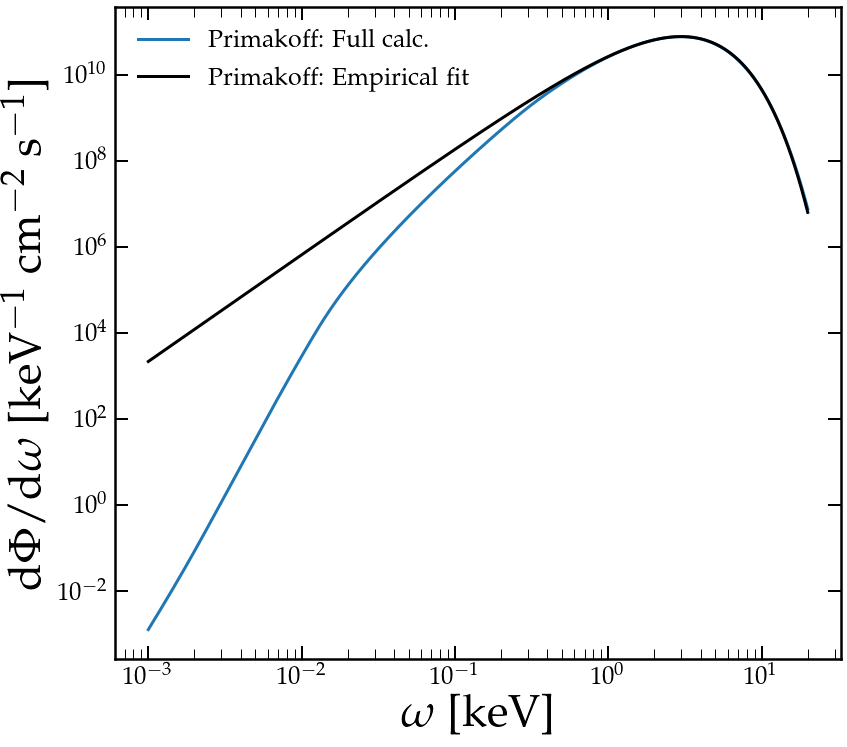

In [2]:
fig,ax = MySquarePlot(r'$\omega$ [keV]',r'$\textrm{d}\Phi/\textrm{d}\omega$ [keV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.loglog(omega_vals,dPhi_P,lw=3,label='Primakoff: Full calc.')

dPhi_P_fit = AxionFlux_Primakoff(1e-10,omega_vals)
plt.loglog(omega_vals,dPhi_P_fit,'k-',lw=3,label='Primakoff: Empirical fit')
plt.legend(frameon=False)

MySaveFig(fig,'PrimakoffFluxes')


In [6]:
def AxionFlux_Primakoff_PlasmonCorrection(gag,omega_vals,nfine=50):
    costh = linspace(-1,0.999,nfine)
    gag_keV = gag/1e6
    nrvals = size(r)
    r_keV = r*Rsol_keV
    dPhi_P = zeros(shape=nvals)
    for i_w in range(0,nvals):
        ka = omega_vals[i_w]
        w = omega_vals[i_w]
        Gam = zeros(shape=nrvals)
        for i_r in range(0,nrvals):
            if w>wp[i_r]:
                kphoton = sqrt(w**2.0-wp[i_r]**2.0)
                x = (ka**2.0+kphoton**2.0)/(2*ka*kphoton)
                y = x + k_S[i_r]**2.0/(2*ka*kphoton)
                Gam[i_r] = (gag_keV**2.0*k_S[i_r]**2.0*T[i_r]/(64*pi))*trapz((1-costh**2.0)/((x-costh)*(y-costh)),costh)
        Gam *= keV_2_s
        dPhi_P[i_w] = (1.0/(AU_cm**2.0))*(w/pi)**2.0*trapz(r_keV**2.0*Gam/(exp(w/T)-1),r_keV)
    return dPhi_P

amax(AxionFlux_Primakoff_PlasmonCorrection(1e-10,omega_vals))

76342611247.65907

# Longitudinal plasmon-axion fluxes

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in power


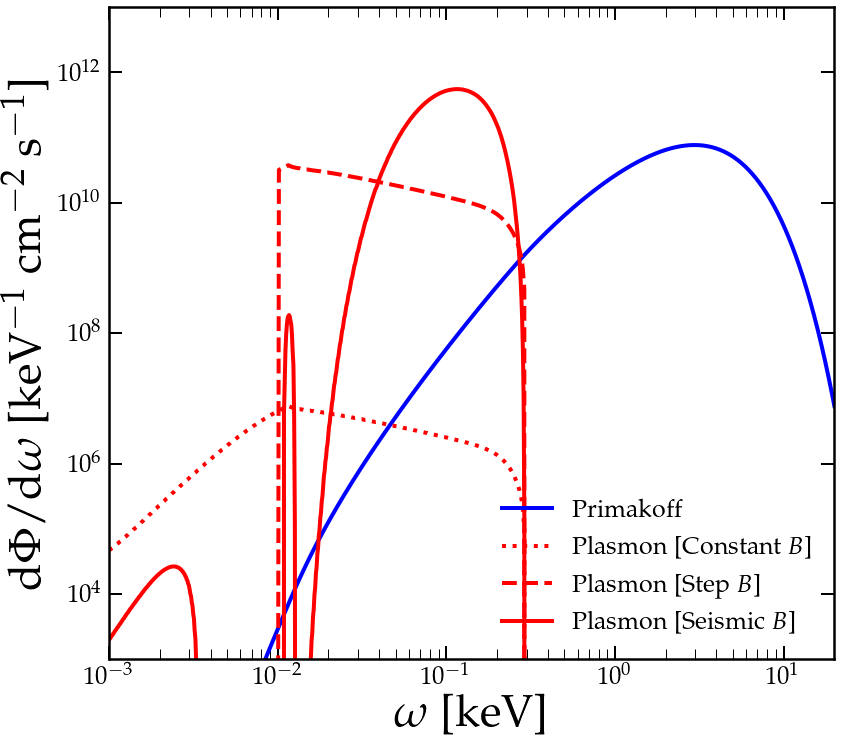

In [15]:
def LplasmonFlux(omega_vals,r,B,T,k_S,wp,gag=1e-10):
    gag_keV = gag/1e6
    B = B*Tesla_2_keV  # B must be in Tesla
    r_keV = r*Rsol_keV
    nvals = size(omega_vals)
    nrvals = size(r)
    dwp = gradient(wp,r_keV)
    dPhi_pl = zeros(shape=nvals)
    for i in range(0,nvals):
        w = omega_vals[i]
        i_r = argmin(abs(w-wp))
        r0 = r_keV[i_r]
        dPhi_pl[i] = keV_2_s*1/(12*pi*AU_cm**2.0)*(r0**2.0)*(w*w)*gag_keV**2.0*(B[i_r]**2.0)/(exp(w/T[i_r])-1)*(1/abs(dwp[i_r-1]))
    return dPhi_pl


fig,ax = MySquarePlot(r'$\omega$ [keV]',r'$\textrm{d}\Phi/\textrm{d}\omega$ [keV$^{-1}$ cm$^{-2}$ s$^{-1}$]')

# Model 1: constant B
B_const = 1e5*1e-4*(r<10.0)

# Model 2: step function B
B_step = 1e-4*((7e6*(r<0.75)+1e3*(r>=0.75)))

# Model 3: from https://arxiv.org/pdf/astro-ph/0203107.pdf
r0_12 = 0.712
lamb = 10*r0_12+1
B12_rad =(1+lamb)*(1+1/lamb)**lamb*5.0e3*(r/r0_12)**2*(1-(r/r0_12)**2.0)**lamb*(r<r0_12)
B12_rad[isnan(B12_rad)] = 0.0
d = 0.02
B12_tach = 50.0*(1-((r-r0_12)/d)**2.0)*(abs(r-r0_12)<d)
B12_tach[isnan(B12_tach)] = 0.0
r0_31 = 0.96
d = 0.035
B12_outer = 3.0*(1-((r-r0_31)/d)**2.0)*(abs(r-r0_31)<d)
B12_outer[isnan(B12_outer)] = 0.0
B_seismic = (B12_rad + B12_tach + B12_outer)



# Plot in log scale
dPhi_pl_const = LplasmonFlux(omega_vals,r,B_const,T,k_S,wp)
dPhi_pl_step = LplasmonFlux(omega_vals,r,B_step,T,k_S,wp)
dPhi_pl_seismic = LplasmonFlux(omega_vals,r,B_seismic,T,k_S,wp)

plt.plot(omega_vals,dPhi_P,'b-',label='Primakoff',lw=4)
plt.plot(omega_vals,dPhi_pl_const,'r:',label='Plasmon [Constant $B$]',lw=4)
plt.plot(omega_vals,dPhi_pl_step,'r--',label='Plasmon [Step $B$]',lw=4)
plt.plot(omega_vals,dPhi_pl_seismic,'r-',label='Plasmon [Seismic $B$]',lw=4)


plt.ylim([1e3,1e13])
plt.xlim([1e-3,20.0])
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(frameon=False)

MySaveFig(fig,'PlasmonFluxes')


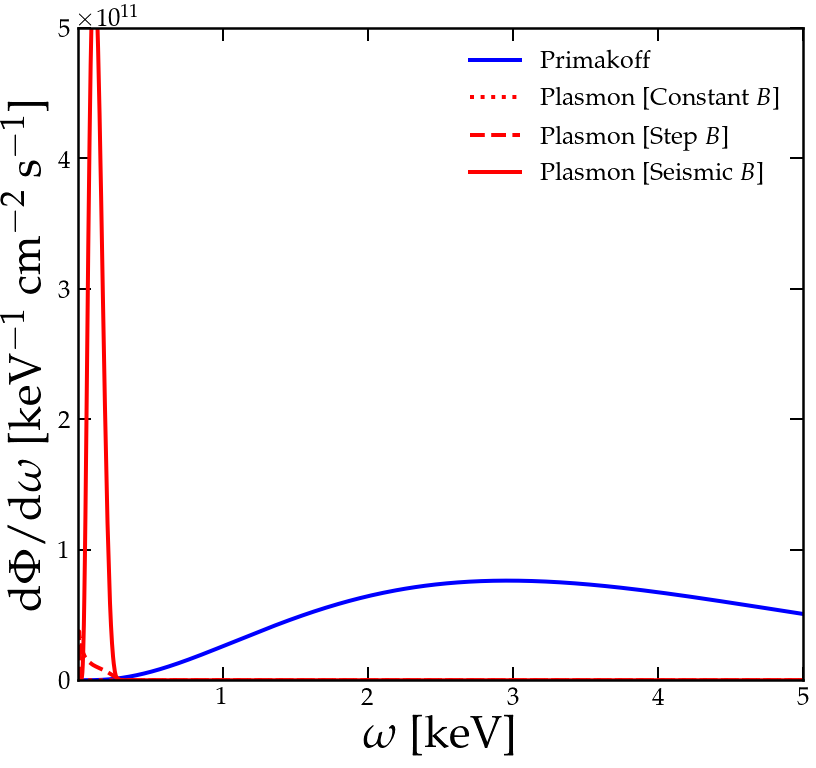

In [4]:

fig,ax = MySquarePlot(r'$\omega$ [keV]',r'$\textrm{d}\Phi/\textrm{d}\omega$ [keV$^{-1}$ cm$^{-2}$ s$^{-1}$]')

plt.plot(omega_vals,dPhi_P,'b-',label='Primakoff',lw=4)
plt.plot(omega_vals,dPhi_pl_const,'r:',label='Plasmon [Constant $B$]',lw=4)
plt.plot(omega_vals,dPhi_pl_step,'r--',label='Plasmon [Step $B$]',lw=4)
plt.plot(omega_vals,dPhi_pl_seismic,'r-',label='Plasmon [Seismic $B$]',lw=4)


plt.ylim([0,5e11])
plt.xlim([1e-3,5.0])
plt.legend(frameon=False)


In [8]:
# Save data
data = column_stack((omega_vals,dPhi_P))
savetxt(data_dir+'solar/saclaymodel/Primakoff.txt',data,header='Saclay seismic solar model \n Primakoff axion flux for g_ag = 1e-10 GeV^{-1} \n omega [keV] \t Flux [keV^{-1} s^{-1} cm^{-2}] ')

data = column_stack((omega_vals,dPhi_pl_const))
savetxt(data_dir+'solar/saclaymodel/Lplasmon_constantB.txt',data,header='Saclay seismic solar model \n Longitudinal plasmon->axion flux for g_ag = 1e-10 GeV^{-1} \n B = 10^5 G \n omega [keV] \t Flux [keV^{-1} s^{-1} cm^{-2}] ')

data = column_stack((omega_vals,dPhi_pl_step))
savetxt(data_dir+'solar/saclaymodel/Lplasmon_stepB.txt',data,header='Saclay seismic solar model \n Longitudinal plasmon->axion flux for g_ag = 1e-10 GeV^{-1} \n B = 7e6 G with step down to 1e3 at 0.75 R_sol \n omega [keV] \t Flux [keV^{-1} s^{-1} cm^{-2}] ')

data = column_stack((omega_vals,dPhi_pl_seismic))
savetxt(data_dir+'solar/saclaymodel/Lplasmon_seismicB.txt',data,header='Saclay seismic solar model \n Longitudinal plasmon->axion flux for g_ag = 1e-10 GeV^{-1} \n B = Seismic model with maximum 5e7 Gauss \n omega [keV] \t Flux [keV^{-1} s^{-1} cm^{-2}] ')


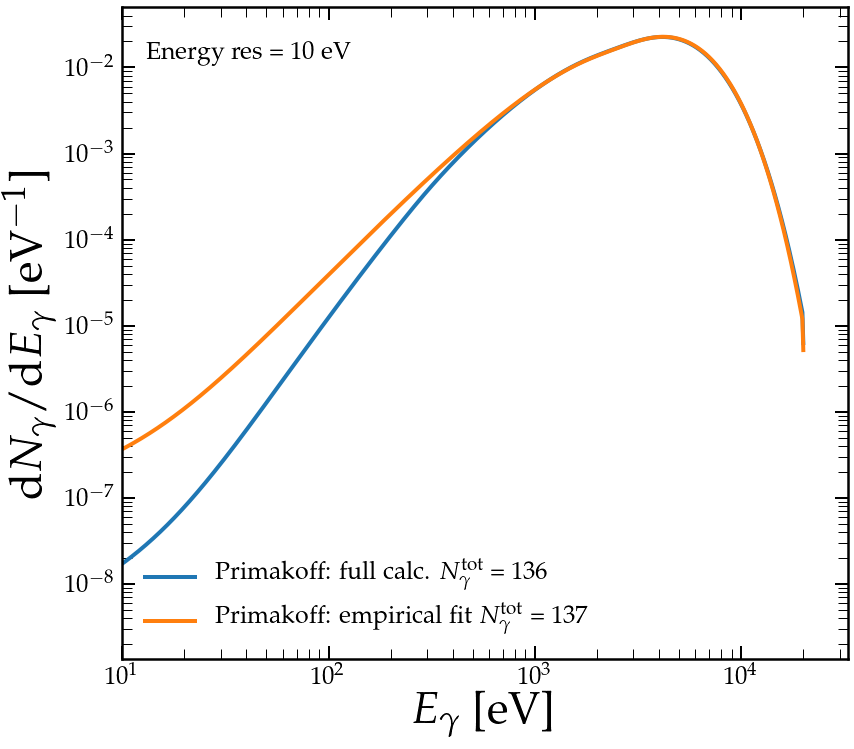

In [14]:
def PhotonNumber_gag(E,Flux10,m_a,g=1e-10,\
    Bfield=2.5,Exposure=1.5,Length=20.0,\
    N_bores=8,BoreDiameter=60.0,eps_D=0.7,eps_T=0.8):
    S_cm = N_bores*pi*(BoreDiameter/2.0)**2.0 # cm^2
    L_eV = Length/1.97e-7 # eV^-1
    t_secs = Exposure*3600*24*365 # s
    B = Bfield*(1e-19*195)
    norm = t_secs*S_cm*eps_D*eps_T*(B*L_eV/2.0)**2.0
    normq = L_eV/(4*1000)
    dN = (g/1.0e-10)**4.0*norm*Flux10*(sinc(normq/pi*m_a**2.0/E))**2.0 # keV^-1
    return dN


fig,ax = MySquarePlot(r"$E_\gamma$ [eV]",r"${\rm d}N_\gamma/{\rm d}E_\gamma$ [eV$^{-1}$]")

ma = 1.0e-4
Eres = 10.0e-3

F1 = smear(omega_vals,PhotonNumber_gag(omega_vals,dPhi_P,ma,g=1e-11),Eres)
F2 = smear(omega_vals,PhotonNumber_gag(omega_vals,dPhi_P_fit,ma,g=1e-11),Eres)

mask = omega_vals>Eres
Ntot1 = trapz(F1[mask],omega_vals[mask])
Ntot2 = trapz(F2[mask],omega_vals[mask])

plt.plot(omega_vals*1000,F1/1000,linewidth=4,label=r'Primakoff: full calc. $N^{\rm tot}_\gamma$ = '+str(int(Ntot1)))
plt.plot(omega_vals*1000,F2/1000,linewidth=4,label=r'Primakoff: empirical fit $N^{\rm tot}_\gamma$ = '+str(int(Ntot2)))

ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(left=Eres*1000)


plt.gcf().text(0.15,0.82,'Energy res = '+str(int(Eres*1000))+' eV')
plt.legend(frameon=False,loc='lower left')

MySaveFig(fig,'PhotonSpectrum_IAXO_PrimakoffComparison')



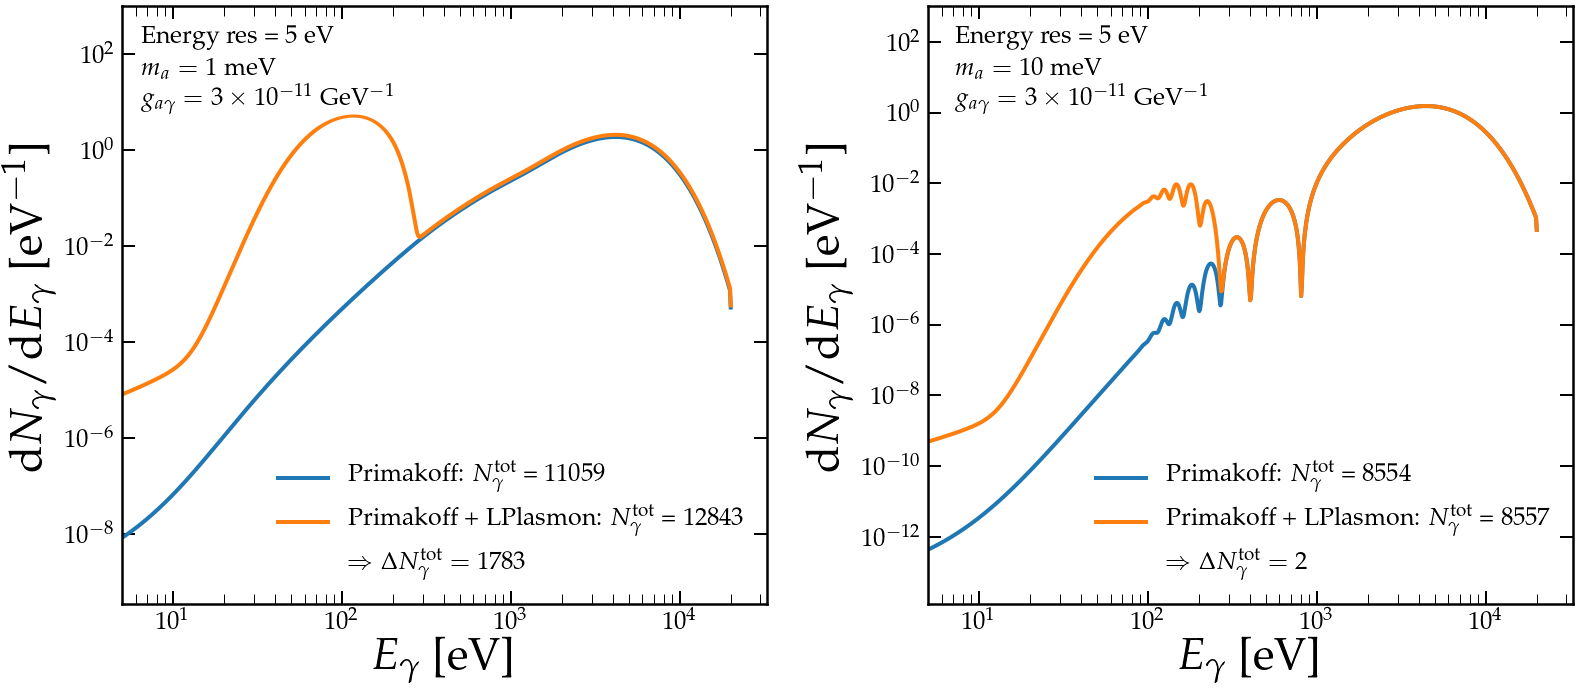

In [13]:
fig,ax1,ax2 = MyDoublePlot(r"$E_\gamma$ [eV]",r"${\rm d}N_\gamma/{\rm d}E_\gamma$ [eV$^{-1}$]",\
                     r"$E_\gamma$ [eV]",r"${\rm d}N_\gamma/{\rm d}E_\gamma$ [eV$^{-1}$]",size_x=26)


Eres = 5e-3
g = 3e-11


ma = 1.0e-3
F1 = smear(omega_vals,PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g),Eres)
F2 = smear(omega_vals,PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g)+\
           PhotonNumber_gag(omega_vals,dPhi_pl_seismic,ma,g=g),Eres)
mask = omega_vals>Eres
Ntot1 = trapz(F1[mask],omega_vals[mask])
Ntot2 = trapz(F2[mask],omega_vals[mask])

ax1.plot(omega_vals*1000,F1/1000,linewidth=4,label=r'Primakoff: $N^{\rm tot}_\gamma$ = '+str(int(Ntot1)))
ax1.plot(omega_vals*1000,F2/1000,linewidth=4,label=r'Primakoff + LPlasmon: $N^{\rm tot}_\gamma$ = '+str(int(Ntot2)))
ax1.plot(omega_vals*1000,F2/1000+0.5,color='w',label=r'$\Rightarrow \Delta N^{\rm tot}_\gamma = $ '+str(int(Ntot2-Ntot1)))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left=Eres*1000)
ax1.set_ylim(top=1e3)
plt.gcf().text(0.135,0.835,'Energy res = '+str(int(Eres*1000))+' eV')
plt.gcf().text(0.135,0.79,'$m_a = 1$ meV')
plt.gcf().text(0.135,0.75,r'$g_{a\gamma} = 3\times10^{-11}$ GeV$^{-1}$')
ax1.legend(frameon=False,loc='lower right')



###
ma = 10.0e-3
F1 = smear(omega_vals,PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g),Eres)
F2 = smear(omega_vals,PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g)+\
           PhotonNumber_gag(omega_vals,dPhi_pl_seismic,ma,g=g),Eres)
mask = omega_vals>Eres
Ntot1 = trapz(F1[mask],omega_vals[mask])
Ntot2 = trapz(F2[mask],omega_vals[mask])

ax2.plot(omega_vals*1000,F1/1000,linewidth=4,label=r'Primakoff: $N^{\rm tot}_\gamma$ = '+str(int(Ntot1)))
ax2.plot(omega_vals*1000,F2/1000,linewidth=4,label=r'Primakoff + LPlasmon: $N^{\rm tot}_\gamma$ = '+str(int(Ntot2)))
ax2.plot(omega_vals*1000,F2/1000+0.5,color='w',label=r'$\Rightarrow \Delta N^{\rm tot}_\gamma = $ '+str(int(Ntot2-Ntot1)))
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(left=Eres*1000)
ax2.set_ylim(top=1e3)
plt.gcf().text(0.57,0.835,'Energy res = '+str(int(Eres*1000))+' eV')
plt.gcf().text(0.57,0.79,'$m_a = 10$ meV')
plt.gcf().text(0.57,0.75,r'$g_{a\gamma} = 3\times10^{-11}$ GeV$^{-1}$')
ax2.legend(frameon=False,loc='lower right')

MySaveFig(fig,'PhotonSpectrum_IAXO_LPlasmon_Eres5')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


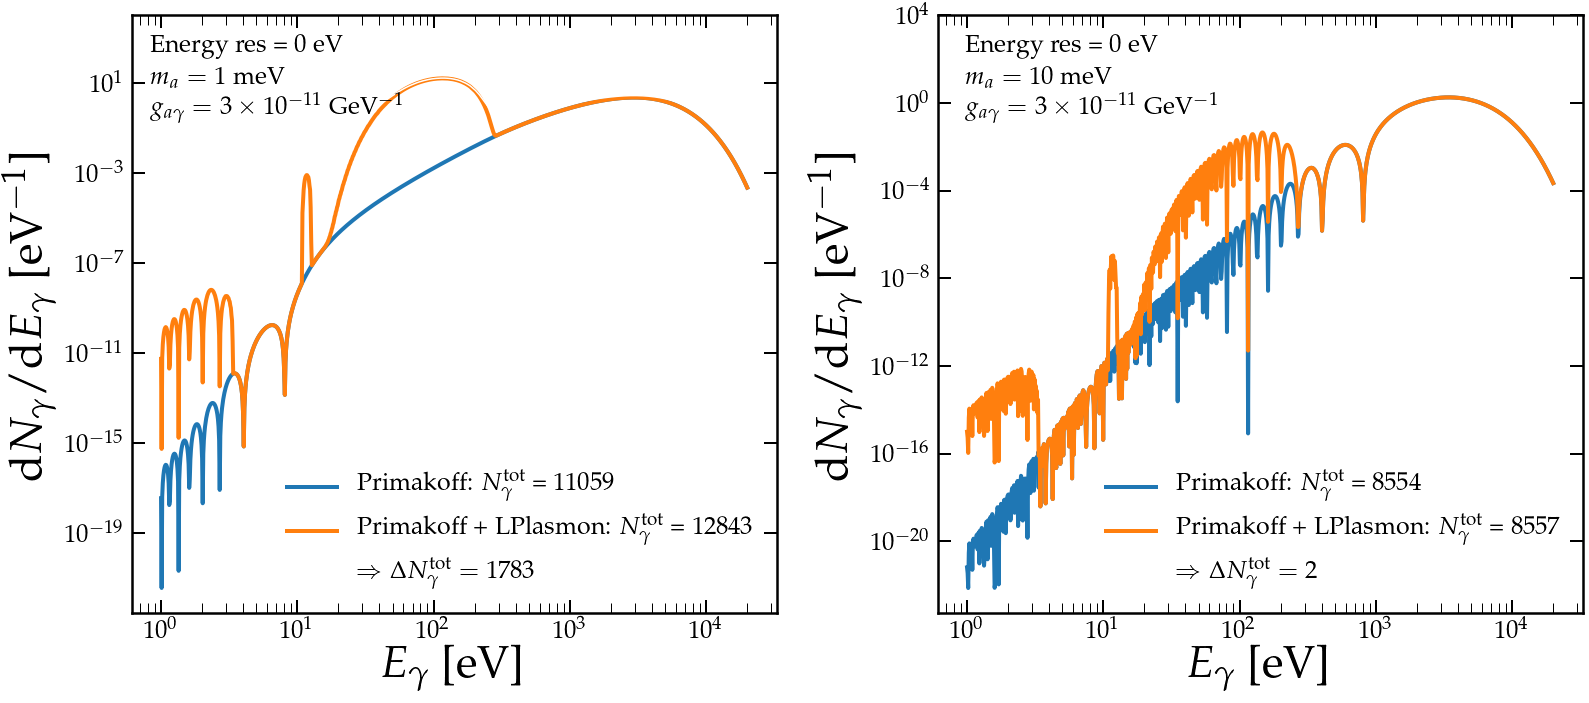

In [12]:
fig,ax1,ax2 = MyDoublePlot(r"$E_\gamma$ [eV]",r"${\rm d}N_\gamma/{\rm d}E_\gamma$ [eV$^{-1}$]",\
                     r"$E_\gamma$ [eV]",r"${\rm d}N_\gamma/{\rm d}E_\gamma$ [eV$^{-1}$]",size_x=26)


#Eres = 5e-3
Eres = 0
g = 3e-11


ma = 1.0e-3
#F1 = smear(omega_vals,PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g),Eres)
#F2 = smear(omega_vals,PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g)+\
#           PhotonNumber_gag(omega_vals,dPhi_pl_seismic,ma,g=g),Eres)
F1 = PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g)
F2 = PhotonNumber_gag(omega_vals,dPhi_pl_seismic,ma,g=g)+PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g)


mask = omega_vals>Eres
Ntot1 = trapz(F1[mask],omega_vals[mask])
Ntot2 = trapz(F2[mask],omega_vals[mask])

ax1.plot(omega_vals*1000,F1/1000,linewidth=4,label=r'Primakoff: $N^{\rm tot}_\gamma$ = '+str(int(Ntot1)))
ax1.plot(omega_vals*1000,F2/1000,linewidth=4,label=r'Primakoff + LPlasmon: $N^{\rm tot}_\gamma$ = '+str(int(Ntot2)))
ax1.plot(omega_vals*1000,F2/1000+0.5,color='w',label=r'$\Rightarrow \Delta N^{\rm tot}_\gamma = $ '+str(int(Ntot2-Ntot1)))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left=0*1000)
ax1.set_ylim(top=1e4)
plt.gcf().text(0.135,0.835,'Energy res = '+str(int(Eres*1000))+' eV')
plt.gcf().text(0.135,0.79,'$m_a = 1$ meV')
plt.gcf().text(0.135,0.75,r'$g_{a\gamma} = 3\times10^{-11}$ GeV$^{-1}$')
ax1.legend(frameon=False,loc='lower right')



###
ma = 10.0e-3
# F1 = smear(omega_vals,PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g),Eres)
# F2 = smear(omega_vals,PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g)+\
#            PhotonNumber_gag(omega_vals,dPhi_pl_seismic,ma,g=g),Eres)
F1 = PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g)
F2 = PhotonNumber_gag(omega_vals,dPhi_pl_seismic,ma,g=g)+PhotonNumber_gag(omega_vals,dPhi_P,ma,g=g)
mask = omega_vals>Eres
Ntot1 = trapz(F1[mask],omega_vals[mask])
Ntot2 = trapz(F2[mask],omega_vals[mask])

ax2.plot(omega_vals*1000,F1/1000,linewidth=4,label=r'Primakoff: $N^{\rm tot}_\gamma$ = '+str(int(Ntot1)))
ax2.plot(omega_vals*1000,F2/1000,linewidth=4,label=r'Primakoff + LPlasmon: $N^{\rm tot}_\gamma$ = '+str(int(Ntot2)))
ax2.plot(omega_vals*1000,F2/1000+10,color='w',label=r'$\Rightarrow \Delta N^{\rm tot}_\gamma = $ '+str(int(Ntot2-Ntot1)))
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(left=Eres*1000)
ax2.set_ylim(top=1e4)
plt.gcf().text(0.57,0.835,'Energy res = '+str(int(Eres*1000))+' eV')
plt.gcf().text(0.57,0.79,'$m_a = 10$ meV')
plt.gcf().text(0.57,0.75,r'$g_{a\gamma} = 3\times10^{-11}$ GeV$^{-1}$')
ax2.legend(frameon=False,loc='lower right')

MySaveFig(fig,'PhotonSpectrum_IAXO_LPlasmon_Eres0')
